In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mpmath import mp
import importlib

import model, analysis, util, implicit_curve

util = importlib.reload(util)
analysis = importlib.reload(analysis)
implicit_curve = importlib.reload(implicit_curve)
model = importlib.reload(model)

## Leptogenesis Process

In [3]:
def do_sim(m_a, Gamma_phi, sigma_eff, theta_0, temp_dep): 
    f_a = 3e14
    H_inf = model.calc_H_inf_max(f_a)
    return model.simulate(m_a, f_a, Gamma_phi, H_inf, 
                            converge=True, fixed_samples=True, 
                            use_cosine_potential=temp_dep, 
                            use_temp_dep_axion_mass=temp_dep,
                            sigma_eff=sigma_eff, theta0=theta_0,)

#decay_sol = model.simulate_axion_decay(m_a, f_a, bg_sol, converge=True, fixed_samples=False)

In [18]:
def make_boltzmann_plots(bg_sols, names):
    plt.figure(figsize=(13, 8))
    plt.subplot(2,2,1)
    for name, bg_sol in zip(names, bg_sols):
        plt.loglog(bg_sol.t, model.calc_Gamma_L(bg_sol.T, model.paper_sigma_eff), label=name)
    plt.legend()
    plt.ylabel(r"$\Gamma_L$")
    plt.xlabel("t * GeV")
    plt.subplot(2,2,3)
    for name, bg_sol in zip(names, bg_sols):
        plt.semilogx(bg_sol.t, 
                     - bg_sol.n_L + model.calc_lepton_asym_in_eqi(bg_sol.T, bg_sol.theta_dot), label=name)
    plt.legend()
    plt.ylabel(r"$(n_L - n_L^\mathrm{eq}) / \mathrm{GeV}^3$")
    plt.xlabel("t * GeV")
    plt.subplot(2,2,2)
    for name, bg_sol in zip(names, bg_sols):
        plt.loglog(bg_sol.t, model.n_L_to_eta_B_final(bg_sol.T, bg_sol.n_L), label=name)
    plt.legend()
    plt.ylabel(r"$\eta_B^\mathrm{final}$")
    plt.xlabel("t * GeV")
    plt.subplot(2,2,4)
    for name, bg_sol in zip(names, bg_sols):
        plt.semilogx(bg_sol.t, bg_sol.theta, label=name)
    plt.legend()
    plt.ylabel(r"$\theta$")
    plt.xlabel("t * GeV")
    plt.tight_layout()
    plt.show()
    

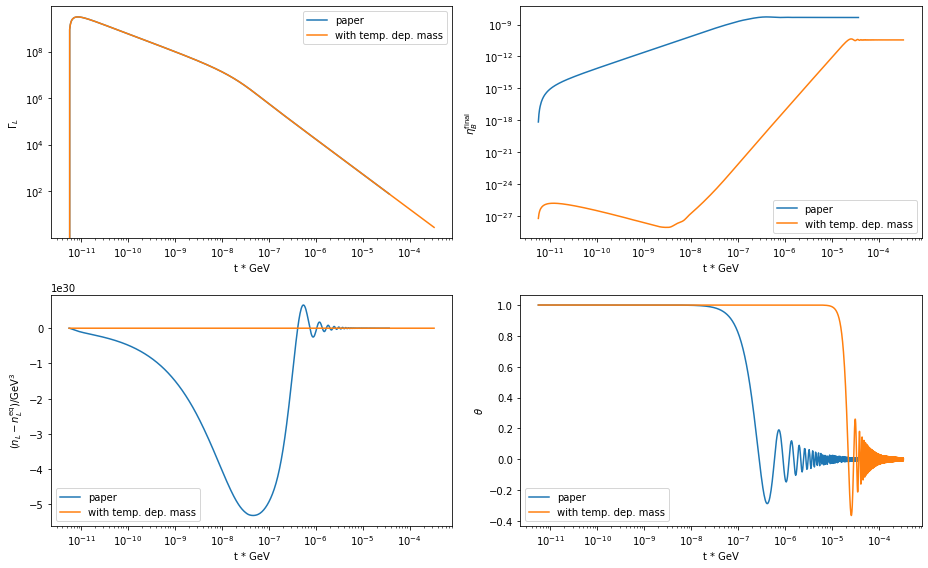

In [19]:
m_a = 1e7
Gamma_phi = 1e8
make_boltzmann_plots([
    do_sim(m_a, Gamma_phi, model.paper_sigma_eff, 1.0, False),
    do_sim(m_a, Gamma_phi, model.paper_sigma_eff, 1.0, True),
    
], [
    "paper", 
    "with temp. dep. mass",
])

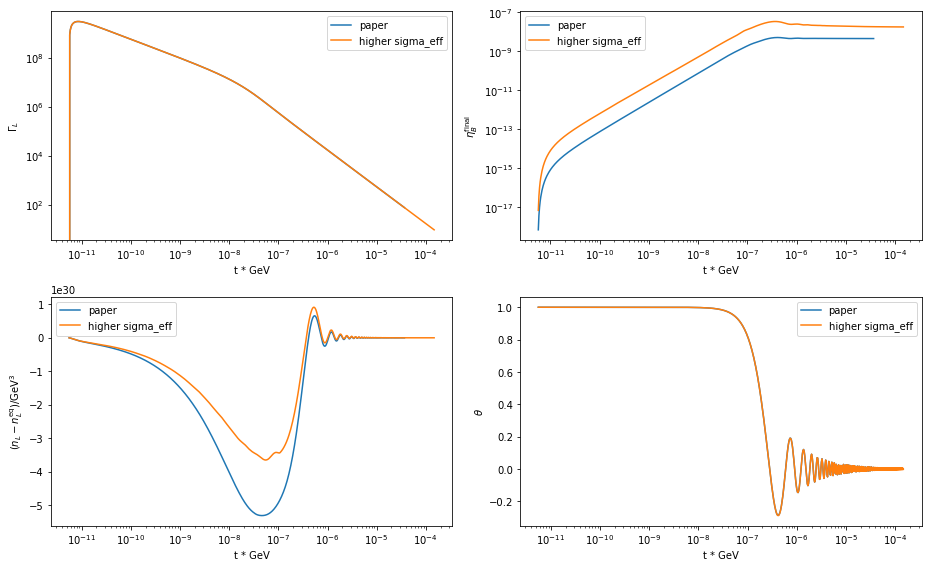

In [20]:
m_a = 1e7
Gamma_phi = 1e8
make_boltzmann_plots([
    do_sim(m_a, Gamma_phi, model.paper_sigma_eff, 1.0, False),
    do_sim(m_a, Gamma_phi, model.paper_sigma_eff * 10, 1.0, False),
    
], [
    "paper", 
    "higher sigma_eff",
])

## Axion Decay

In [40]:
paper_decay_rate_prefactor = model.alpha**2 / (64 * np.pi**3)
def compute_dilution_factor(f_a, m_a=1e7, Gamma_phi=1e8, decay_rate_prefactor=paper_decay_rate_prefactor):
    def calc_Gamma_a(m_a, f_a):
        return decay_rate_prefactor * m_a**3 / f_a**2
    H_inf = model.calc_H_inf_max(f_a)
    bg_sol = model.simulate(m_a, f_a, Gamma_phi, H_inf, fixed_samples=False, converge=True)
    decay_sol = model.simulate_axion_decay(m_a, f_a, bg_sol, 
                                           fixed_samples=False, converge=True, calc_Gamma_a_fn=calc_Gamma_a)
    start = model.n_L_to_eta_B_final(bg_sol.T[-1], bg_sol.n_L[-1])
    end = model.n_L_to_eta_B_final(decay_sol.T[-1], decay_sol.n_L[-1])
    return end / start

In [41]:
f_a_range = np.geomspace(1e9, 1e16, 30)
m_a_range = np.geomspace(5e5, 1e10, 5)
dilution_factor = [[compute_dilution_factor(f_a, m_a=m_a) for f_a in f_a_range] for m_a in tqdm(m_a_range)]
dilution_factor_larger_decay_rate = [[compute_dilution_factor(f_a, m_a=m_a, 
                                                              decay_rate_prefactor=10*paper_decay_rate_prefactor) 
                                      for f_a in f_a_range] for m_a in tqdm(m_a_range)]

/home/jana/Documents/master-project/axion_spg/model.py:283: RuntimeWarning: overflow encountered in exp
  rho_R, rho_a, R = np.exp(y)
/home/jana/Documents/master-project/axion_spg/model.py:287: RuntimeWarning: invalid value encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)
/home/jana/Documents/master-project/axion_spg/model.py:287: RuntimeWarning: divide by zero encountered in double_scalars
  d_log_rho_R_d_log_t = - t * (4 * H - Gamma_a * rho_a / rho_R)


(1000000000000.0, 1e+16)

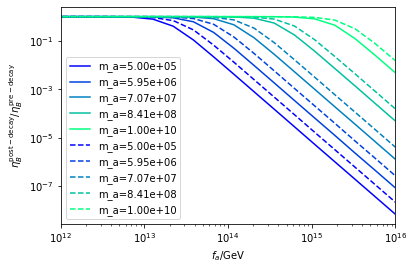

In [45]:
cmap = plt.get_cmap("winter")
for x, m_a, df in zip(np.linspace(0, 1, len(m_a_range)), m_a_range, dilution_factor):
    plt.loglog(f_a_range, df, "-", color=cmap(x), label=f"m_a={m_a:.2e}")
for x, m_a, df in zip(np.linspace(0, 1, len(m_a_range)), m_a_range, dilution_factor_larger_decay_rate):
    plt.loglog(f_a_range, df, "--", color=cmap(x), label=f"m_a={m_a:.2e}")
plt.xlabel(r"$f_a / \mathrm{GeV}$")
plt.ylabel(r"$\eta_B^\mathrm{post-decay} / \eta_B^\mathrm{pre-decay}$")
plt.legend()
plt.xlim(1e12, f_a_range[-1])